# Weekly stock price reversal trading strategy

- Contrarian trading (Lo and Mackinlay 1990, and others), statistical arbitrage
- implementation shortfall
- structural break with unknown changepoint

Copyright 2023, Terence Lim

MIT License

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series, to_datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
from finds.database import SQL, Redis
from finds.busday import BusDay, WeeklyDay
from finds.structured import CRSP, Benchmarks
from finds.recipes import fractiles, lm
from finds.display import row_formatted, show
from conf import credentials, VERBOSE, paths

%matplotlib inline
VERBOSE = 0
SHOW = dict(ndigits=4, latex=None)

sql = SQL(**credentials['sql'], verbose=VERBOSE)
rdb = Redis(**credentials['redis'])
bd = BusDay(sql, verbose=VERBOSE)
crsp = CRSP(sql, bd, rdb=rdb, verbose=VERBOSE)
bench = Benchmarks(sql, bd)
imgdir = paths['images']
endweek = 20220331   # Thursday close
endweek = 20220401   # Friday close

## Construct weekly reversal

In [2]:
begweek = 19740102   # increased stocks coverage in CRSP in Jan 1973
middate = 19851231   # increased stocks traded in CRSP around this date
wd = WeeklyDay(sql, bd(endweek).strftime('%A'))   # Generate weekly cal
rebaldates = wd.date_range(begweek, endweek)
retdates = wd.date_tuples(rebaldates)

# Retrieve weekly returns, standardize scores, and compute returns and i.c.
june_universe = 0  # to track when reached a June end to update universe
year = 0           # to track new year to retrieve prices in batch
results = []
lagged_weights = Series(dtype=float) # to track "turnover" of stock weights

# loop over weekly rebalance dates
for rebaldate, pastdates, nextdates in tqdm(zip(rebaldates[1:-1], retdates[:-1],
                                                retdates[1:])):
    # screen universe each June: largest 5 size deciles
    d = bd.june_universe(rebaldate)
    if d != june_universe:  # need next June's universe
        june_universe = d                        # update universe every June
        univ = crsp.get_universe(june_universe)  # usual CRSP universe screen
        univ = univ[univ['decile'] <= 9]         # drop smallest half stocks

    # retrieve new annual batch of daily prices and returns when start year
    if bd.begyr(rebaldate) != year:
        year = bd.begyr(rebaldate)
        prc = crsp.get_range(dataset='daily',
                             fields=['bidlo', 'askhi', 'prc', 'retx', 'ret'],
                             date_field='date',
                             beg=year,
                             end=bd.offset(bd.endyr(year), 10),
                             cache_mode="rw")

    # get past week's returns, require price at start of week
    past_week = prc[prc.index.get_level_values('date') == rebaldate]['prc']\
        .reset_index()\
        .set_index('permno')\
        .join(crsp.get_ret(*pastdates).reindex(univ.index))\
        .dropna()

    # convert past week's minus returns to standardized weights in portfolio
    weights = ((past_week['ret'].mean() - past_week['ret']) /
               (past_week['ret'].std(ddof=0) * len(past_week)))

    # turnover = total abs change in stock weight, scaled by total abs weight
    chg_weights = pd.concat([weights, -lagged_weights], axis=1)\
                       .fillna(0)\
                       .sum(axis=1)
    total_weight = weights.abs().sum() + lagged_weights.abs().sum()
    lagged_weights = weights
    
    # get next week's returns
    next_week = crsp.get_ret(*nextdates).reindex(past_week.index).fillna(0)

    # get next day's prices, to compute one-day delay cost
    next_day = prc[prc.index.get_level_values('date')==bd.offset(rebaldate, 1)]\
        .reset_index()\
        .set_index('permno')\
        .drop(columns='date')\
        .reindex(chg_weights.index)
    avgprc = next_day[['bidlo', 'askhi', 'prc']].abs().mean(axis=1)

    # if no trade next day, then enter position at askhi (long) or bidlo (short)
    bidask = next_day['askhi'].where(weights > 0, next_day['bidlo']).abs()
    avgprc = next_day['prc'].where(next_day['prc'] > 0, bidask)

    # delay slippage (positive is cost) = weights chg * drift of next day price
    drift = avgprc.div(next_day['prc'].abs())\
                  .mul(1 + next_day['ret'])\
                  .sub(1)\
                  .fillna(0)

    # accumulate weekly computations
    results.append(DataFrame({'ret': weights.dot(next_week),
                              'ic': weights.corr(next_week),
                              'n': len(next_week),
                              'beg': nextdates[0],
                              'end': nextdates[1],
                              'absweight': np.sum(weights.abs()),
                              'turnover': chg_weights.abs().sum()/total_weight,
                              'vol': next_week.std(ddof=0),
                              'delay': chg_weights.dot(drift)},
                             index=[rebaldate]))

# Combine accumulated weekly computations
df = pd.concat(results, axis=0)
dates = df.index
df.index = pd.DatetimeIndex(df.index.astype(str))

# Show summary
cols = ['ic' ,'vol', 'ret', 'delay', 'turnover']
indexes = ['Information coefficient', 'Cross-sectional Volatility',
           'Alpha (gross return)', 'Delay cost', 'Portfolio turnover']
show(pd.concat([df[cols].mean(axis=0).rename('mean'),
                df[cols].std(axis=0).rename('std')],
               axis=1).set_index(pd.Index(indexes)),
     caption=f'Summary of Weekly Mean Reversion Strategy {dates[0]}-{dates[-1]}',
     **SHOW)

Last FamaFrench Date 2022-11-30 00:00:00


2516it [01:12, 34.76it/s]


,mean,std
Summary of Weekly Mean Reversion Strategy 19740111-20220325,,
Information coefficient,0.0411,0.0925
Cross-sectional Volatility,0.0580,0.0195
Alpha (gross return),0.0025,0.0071
Delay cost,0.0017,0.0047
Portfolio turnover,0.7373,0.0377


## Plot returns, and rolling avg information coefficient and cross-sectional vol

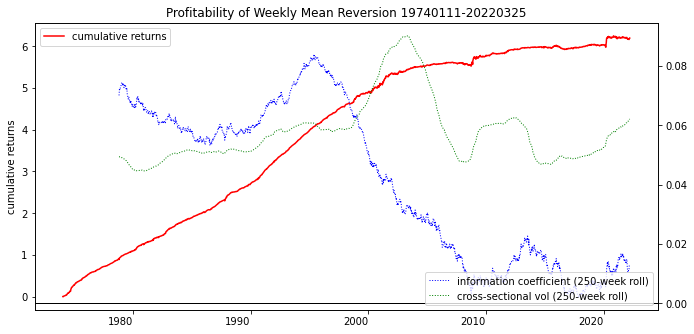

In [3]:
fig, ax = plt.subplots(num=1, clear=True, figsize=(10, 5))
df['ret'].cumsum().plot(ax=ax, ls='-', color='r', rot=0)
ax.legend(['cumulative returns'], loc='upper left')
ax.set_ylabel('cumulative returns')

bx = ax.twinx()
roll = 250  # 250 week rolling average ~ 5 years
df['ic'].rolling(roll).mean().plot(ax=bx, ls=':', lw=1, rot=0, color='b')
df['vol'].rolling(roll).mean().plot(ax=bx, ls=':', lw=1, rot=0, color='g')
#bx.axhline(df['ic'].mean(), linestyle='-', color='C0', lw=2)
bx.axhline(0, linestyle='-', color='black', lw=1)
bx.legend([f"information coefficient ({roll}-week roll)",
           f"cross-sectional vol ({roll}-week roll)"],
          loc='lower right')
ax.set_title(f'Profitability of Weekly Mean Reversion {dates[0]}-{dates[-1]}')
plt.tight_layout(pad=2)
plt.savefig(imgdir / 'weekrev.jpg')

## Structural Break Test with Unknown Changepoint

In [4]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from finds.pyR import PyR
importr('strucchange')   # R package to use

# Set up data and formulas for R
Y = df['ret']
#dates = to_datetime(df.index.astype(str))
formula = ro.Formula('y ~ 1')
formula.environment['y'] = PyR(Y.values).ro

# Call R strucchange routines to compute breakpoint statistics
fstats_r = ro.r['Fstats'](formula, **{'from': 1})    # Fstats at every break
breakpoints_r = ro.r['breakpoints'](formula)         # candidate breakpoints
confint_r = ro.r['confint'](breakpoints_r, breaks=1) # conf interval for 1 break
sctest_r = ro.r['sctest'](fstats_r, **{'type': 'aveF'})

### Extract output from R results

In [5]:
confint = PyR(confint_r[0]).frame.iloc[0].astype(int) - 1  # R index starts at 1
output = dict(zip(confint.index, df.index[confint]))       # confidence interval
for k,v in zip(sctest_r.slots['names'][:3], sctest_r[:3]): # significance values
    output[k] = PyR(v).values[0]
output['mean(pre)'] = Y[df.index <= output['breakpoints']].mean() 
output['mean(post)'] = Y[df.index > output['breakpoints']].mean()
fstat = [0] + list(PyR(fstats_r[0]).values) + [0, 0]  # pad beyond from and to 

show(DataFrame(output, index=['sctest']),
     caption="Structural break test with unknown changepoint", **SHOW)

,2.5 %,breakpoints,97.5 %,statistic,p.value,method,mean(pre),mean(post)
Structural break test with unknown changepoint,,,,,,,,
sctest,2000-02-18,2001-12-28,2002-10-18,36.6148,0.0,aveF test,0.0037,0.0008


### Plot breakpoint F-stats

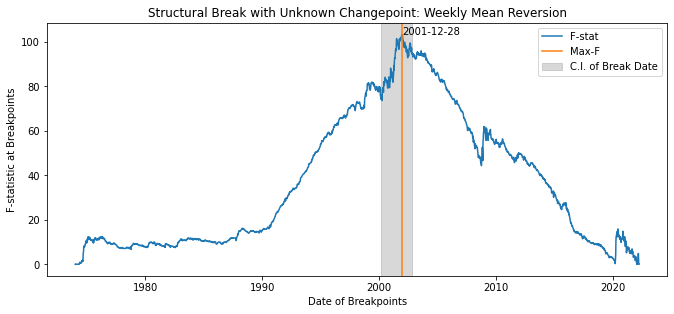

In [6]:
fig, ax = plt.subplots(num=2, clear=True, figsize=(10, 5))
ax.plot(df.index, fstat, color='C0')
arg = np.nanargmax(fstat)
ax.axvline(df.index[arg], color='C1')
ax.axvspan(df.index[confint[0]], df.index[confint[2]], alpha=0.3, color='grey')
ax.legend(['F-stat', 'Max-F', 'C.I. of Break Date'])
ax.annotate(df.index[arg].strftime('%Y-%m-%d'), xy=(df.index[arg], fstat[arg]))
ax.set_ylabel('F-statistic at Breakpoints')
ax.set_xlabel('Date of Breakpoints')
ax.set_title('Structural Break with Unknown Changepoint: '
             'Weekly Mean Reversion')
plt.tight_layout(pad=3)
plt.savefig(imgdir / 'break.jpg')

### Compute gross annualized sharpe ratio and delay slippage

In [7]:
market = bench.get_series(permnos=['Mkt-RF'], field='ret').reset_index()
breakpoint = BusDay.to_date(output['breakpoints'])
out = dict()
for select, period in zip([dates > 0, dates <= breakpoint, dates > breakpoint],
                          ['Full', 'Pre-break', 'Post-break']):
    res = df[select].copy()
    res.index = dates[select]

    # align market returns and compute market regression beta
    #res['date'] = res.index
    res['mkt'] = [(1 + market[market['date'].between(*dt)]['Mkt-RF']).prod() - 1
                  for dt in res[['beg','end']].itertuples(index=False)]
    model = lm(res['mkt'], res['ret'], flatten=True)
    
    # save df summary
    out[f"{period} Period"] = {
        'start date': min(res.index),
        'end date': max(res.index),
        'Sharpe Ratio': np.sqrt(52)*res['ret'].mean()/res['ret'].std(),
        'Average Return': res['ret'].mean(),
        'Std Dev Return': res['ret'].std(),
        'Market Beta': model.coefficients[1],
        'Jensen Alpha (annualized)': model.coefficients[0] * 52,
        'Appraisal Ratio': np.sqrt(52) * model.coefficients[0] / model.stderr,
        'Information Coefficient': res['ic'].mean(),
        'Cross-sectional Vol': res['vol'].mean(),
        'Delay cost': res['delay'].mean(),
        'Turnover Fraction': res['turnover'].mean(),
        #'Abs Weight': res['absweight'].mean(),
        'Num Stocks': int(res['n'].mean()),
    }

# Display as formatted DataFrame
formats = dict.fromkeys(['start date' ,'end date', 'Num Stocks'], '{:.0f}')
show(row_formatted(DataFrame(out), formats=formats, default='{:.4f}'),
     caption="Subperiod Performance of Weekly Mean Reversion Strategy", **SHOW)

,Full Period,Pre-break Period,Post-break Period
Subperiod Performance of Weekly Mean Reversion Strategy,,,
start date,19740111,19740111,20020104
end date,20220325,20011228,20220325
Sharpe Ratio,2.4854,4.4925,0.6890
Average Return,0.0025,0.0037,0.0008
Std Dev Return,0.0071,0.0059,0.0083
Market Beta,0.0893,0.0568,0.1263
Jensen Alpha (annualized),0.1207,0.1867,0.0293
Appraisal Ratio,2.4491,4.4996,0.5285
Information Coefficient,0.0411,0.0624,0.0116
